# ANZ virtual internship 
## Building a salary predicting model

Build a simple regression model to predict the annual salary for each customer using the attributes you identified earlier. 

How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?

For a challenge: build a decision-tree based model to predict salary. Does it perform better? How would you accurately test the performance of this model?

# Import libraries and data

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_theme(style='whitegrid')
%matplotlib inline

### Load file

In [351]:
df = pd.read_excel('anz_new_feats.xlsx')
df.head(2)

,status,card_present_flag,account,currency,txn_description,merchant_id,first_name,balance,gender,age,...,state,annual_salary,avg_weekly_purch_num,avg_weekly_trans_num,no_trans_days,avg_trans_amount,max_amount,num_large_trans,avg_trans_amount_overall,med_balance
0,authorized,1.0,ACC-1598451071,AUD,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,F,26,...,QLD,56765,76,83,82,18,1452.2,4,45,1580.4
1,authorized,0.0,ACC-1598451071,AUD,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,F,26,...,QLD,56765,76,83,82,18,1452.2,4,45,1580.4


### Encoding categorical features

In [352]:
cat_feats = df[['status', 'txn_description', 'gender', 'state', 'age_bin']]

In [353]:
cat_feats = pd.get_dummies(cat_feats, drop_first=True)
cat_feats.head(2)

,status_posted,txn_description_PAY/SALARY,txn_description_PAYMENT,txn_description_PHONE BANK,txn_description_POS,txn_description_SALES-POS,gender_M,state_NT,state_QLD,state_SA,state_VIC,state_WA,age_bin_below20,age_bin_btwn20n40,age_bin_btwn40n60
0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


In [354]:
num_feats = df[['balance', 'amount', 'annual_salary', 'avg_weekly_purch_num', 'avg_weekly_trans_num', 'no_trans_days', 
'avg_trans_amount', 'max_amount', 'num_large_trans', 'avg_trans_amount_overall', 'med_balance']]
num_feats.head(3)

,balance,amount,annual_salary,avg_weekly_purch_num,avg_weekly_trans_num,no_trans_days,avg_trans_amount,max_amount,num_large_trans,avg_trans_amount_overall,med_balance
0,35.39,16.25,56765,76,83,82,18,1452.2,4,45,1580.40
1,21.20,14.19,56765,76,83,82,18,1452.2,4,45,1580.40
2,5.71,6.42,52110,39,43,70,35,2349.6,7,78,1132.66


## Check correlation

In [355]:
num_feats.corr()['annual_salary'].sort_values(ascending=False)

annual_salary               1.000000
avg_trans_amount_overall    0.538656
med_balance                 0.258076
balance                     0.257159
amount                      0.091111
avg_trans_amount            0.044312
num_large_trans            -0.045275
avg_weekly_trans_num       -0.079352
max_amount                 -0.097739
no_trans_days              -0.172765
avg_weekly_purch_num       -0.189532
Name: annual_salary, dtype: float64

### Scale numerical features

In [356]:
from sklearn.preprocessing import MinMaxScaler

In [357]:
numerical_feats = num_feats.drop('annual_salary', axis=1)

In [358]:
scaler_x = MinMaxScaler()
num_feats_scaled = scaler_x.fit_transform(numerical_feats)

salary = df['annual_salary'].values.reshape(-1, 1)
scaler_y = MinMaxScaler()
salary_scaled = scaler_y.fit_transform(salary)

In [359]:
# get column names
scaled_num_df = pd.DataFrame(data = num_feats_scaled, columns = numerical_feats.columns, index = numerical_feats.index)
# Pass the index of df_merged_num, otherwise it will sum up the index.

In [360]:
scaled_y = pd.DataFrame(data = salary_scaled, columns = ['annual_salary'], index = numerical_feats.index)

In [361]:
# merge model features to one dataframe
frames = [scaled_num_df, cat_feats]
model_feats = pd.concat(frames, axis=1)

### Split train and test data

In [362]:
X = model_feats
y = scaled_y

In [363]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Define data

In [320]:
num_feats = num_feats.drop('annual_salary', axis=1)

In [321]:
# merge model features to one dataframe
frames = [num_feats, cat_feats]
model_feats = pd.concat(frames, axis=1)

### Split train and test data

In [322]:
X = model_feats
y = df['annual_salary']

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Gradient boosting for regression

In [324]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [325]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [326]:
model = GradientBoostingRegressor(**params)

In [327]:
y_train = y_train.values.ravel()

In [328]:
# fit the model on the whole dataset
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [329]:
boost_preds = model.predict(X_test)

### Valuating the model

In [330]:
from sklearn import metrics
from sklearn.metrics import r2_score, explained_variance_score

In [331]:
print('R-squared', r2_score(y_test, boost_preds)) # accounts for the variation
print('MAE:', metrics.mean_absolute_error(y_test, boost_preds))
print('MSE:', metrics.mean_squared_error(y_test, boost_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, boost_preds))) # directly comparable witht data, $

R-squared 0.9970914391522693
MAE: 1130.8006388456656
MSE: 2038751.0424581876
RMSE: 1427.8483961745335


In [275]:
# preds_lm = preds_lm.reshape(-1, 1)

In [276]:
# y_test = y_test.values.reshape(-1, 1)

In [277]:
# inverse scaling
# boost_preds = scaler_y.inverse_transform(boost_preds)
# y_test = scaler_y.inverse_transform(y_test)

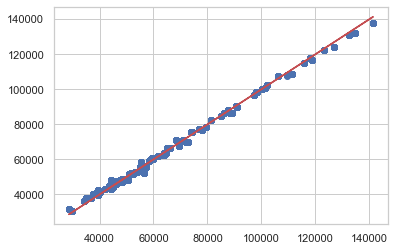

In [332]:
# Our predictions
plt.scatter(y_test, boost_preds)

# Perfect predictions
plt.plot(y_test, y_test,'r')

In [347]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, boost_preds in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, boost_preds)

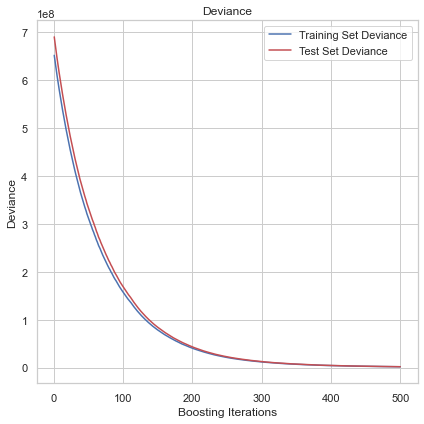

In [348]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## Creating a  Linear Regression Model

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error, r2_score

In [17]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
preds_lm = lm.predict(X_test)

### Valuating the model

In [19]:
from sklearn import metrics
from sklearn.metrics import r2_score, explained_variance_score

In [20]:
print('R-squared', r2_score(y_test, preds_lm)) # accounts for the variation
print('MAE:', metrics.mean_absolute_error(y_test, preds_lm))
print('MSE:', metrics.mean_squared_error(y_test, preds_lm))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, preds_lm))) # directly comparable witht data, $

R-squared 0.8370885822640108
MAE: 0.072520450862627
MSE: 0.008982331048738218
RMSE: 0.0947751605049457


In [21]:
preds_lm = preds_lm.reshape(-1, 1)

array([[0.05207981],
       [0.32040445],
       [0.19908235],
       ...,
       [0.06548177],
       [0.53911698],
       [0.19825551]])

In [22]:
y_test = y_test.values.reshape(-1, 1)

array([[0.13111076],
       [0.36333724],
       [0.20830673],
       ...,
       [0.15408152],
       [0.65140308],
       [0.20830673]])

In [23]:
preds_lm = scaler_y.inverse_transform(preds_lm)
y_test = scaler_y.inverse_transform(y_test)

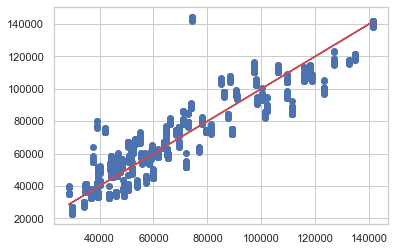

In [24]:
# Our predictions
plt.scatter(y_test, preds_lm)

# Perfect predictions
plt.plot(y_test, y_test,'r')

In [30]:
# Test data real sale price dataframe
test_salary_df = pd.DataFrame(y_test, columns=['Test Y'])

# Predicted prices dataframe
preds_reshape = pd.Series(preds_lm.reshape(3576,))
preds = pd.DataFrame(preds_reshape, columns = ['Predicted'])

# Merge real price and predicted price dataframes
compare_salary_df = pd.merge(test_salary_df, preds, how = 'inner', left_index = True, right_index = True)
compare_salary_df.head(5)

,Test Y,Predicted
0,43406.0,34495.102713
1,69590.0,64749.242041
2,52110.0,51069.933664
3,79524.0,73742.088129
4,59290.0,63680.540175


In [31]:
# Add a new column with error in prediction compared
compare_salary_df['Error'] = compare_salary_df['Test Y'] - compare_salary_df['Predicted']

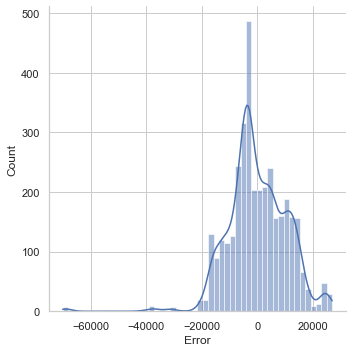

In [32]:
sns.displot(compare_salary_df['Error'], bins = 50, kde = True)

# Gradient boosting for regression

### Define data

In [320]:
num_feats = num_feats.drop('annual_salary', axis=1)

In [321]:
# merge model features to one dataframe
frames = [num_feats, cat_feats]
model_feats = pd.concat(frames, axis=1)

### Split train and test data

In [322]:
X = model_feats
y = df['annual_salary']

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [324]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [325]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [326]:
model = GradientBoostingRegressor(**params)

In [327]:
y_train = y_train.values.ravel()

In [328]:
# fit the model on the whole dataset
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [329]:
boost_preds = model.predict(X_test)

### Valuating the model

In [330]:
from sklearn import metrics
from sklearn.metrics import r2_score, explained_variance_score

In [331]:
print('R-squared', r2_score(y_test, boost_preds)) # accounts for the variation
print('MAE:', metrics.mean_absolute_error(y_test, boost_preds))
print('MSE:', metrics.mean_squared_error(y_test, boost_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, boost_preds))) # directly comparable witht data, $

R-squared 0.9970914391522693
MAE: 1130.8006388456656
MSE: 2038751.0424581876
RMSE: 1427.8483961745335


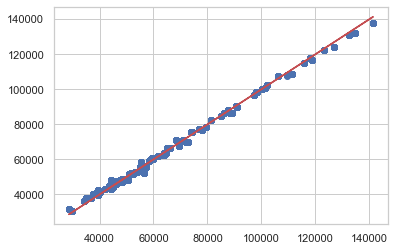

In [332]:
# Our predictions
plt.scatter(y_test, boost_preds)

# Perfect predictions
plt.plot(y_test, y_test,'r')

In [347]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, boost_preds in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, boost_preds)

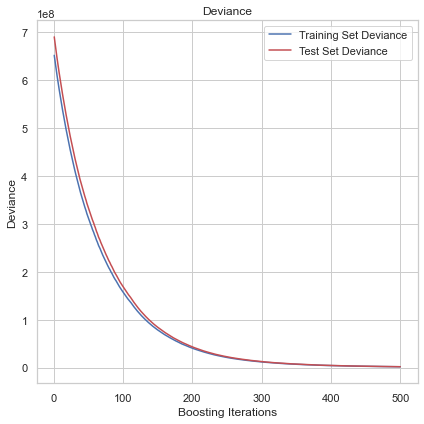

In [348]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()